### Imports

In [85]:
from XRDXRFutils import DatabaseXRD, DataXRD, SpectraXRD, GaussNewton, PhaseList, PhaseMap, PhaseSearch, PhaseMapSave

import os
import pickle


from joblib import Parallel, delayed
import h5py
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, least_squares

from numpy import linspace,concatenate,sqrt,log,histogram
from matplotlib.pyplot import sca,fill_between,legend,imshow,subplots,plot,xlim,ylim,xlabel,ylabel,cm,title,scatter,colorbar,figure,vlines
from sklearn.cluster import KMeans,MiniBatchKMeans

from PIL import Image

def f_linear(x,a,b):
    return a*x + b
def f_loss(x,t,y):
    return (x[0]*t + x[1]) - y

#### Define Paths and Spectra Parameters

In [86]:
path_xrd = '/home/shared/dataXRDXRF/MuseoEgizio2022/VoltoGeroglifici/'
path_database = '/home/shared/DatabaseXRD'

path_data = 'data/' # data of intermediate results, for fast loading
path_figures = 'figures/' # figures generated by the script
path_results = 'results/' # results generated by the script: raw data, tif maps

min_theta = 17
max_theta = 43
min_intensity = 0.1 # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None # selects the first n most intense peaks (if None, leaves all the peaks)

#### Read XRD Data

from xrd.h5

In [87]:
try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5')
except:
    print('Reading from raw data.')
    data = DataXRD().read_params(path_xrd + 'Scanning_Parameters.txt').read(path_xrd).calibrate_from_file(path_xrd + 'calibration.ini').save_h5(path_xrd + 'xrd.h5')

Loading: /home/shared/dataXRDXRF/MuseoEgizio2022/VoltoGeroglifici/xrd.h5


#### Print calibration parameters

In [6]:
print("a: %.1f s: %.1f beta: %.3f"%(data.opt[0],data.opt[1],data.opt[2]))

a: -1327.1 s: 2729.8 beta: 43.202


#### Display datacube

This is only to check. Shows sum across the spectra dimension.

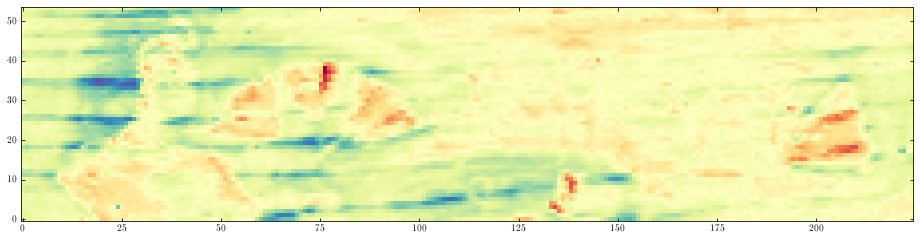

In [84]:
figure(figsize=(16,8))
im = imshow(data.data.sum(axis=2),cmap='Spectral')

For the large datacubes the datasize can be easily reduced using [::n,::n]
where every $n$th pixel is taken

Notes:
Please keep in mind that this rewrites the original dataset so to return the datacube must be reloaded

In [5]:
data.data = data.data[::3,::3]

Display reduced datacube

when $n=3$ every third pixel is taken 

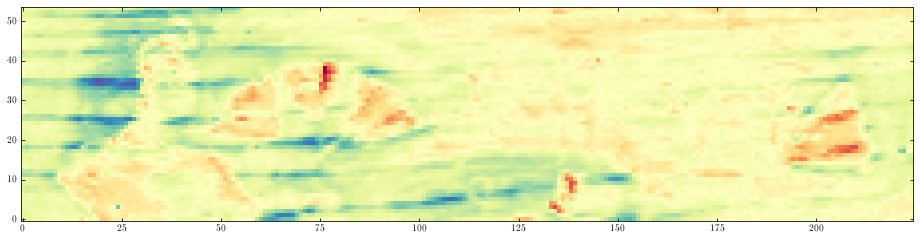

In [83]:
figure(figsize=(16,8))
imshow(data.data.sum(axis=2),cmap='Spectral')

#### Read database

In [88]:
database = DatabaseXRD().read_cifs(path_database)
print('Phases in database:',len(database))

Phases in database: 137


#### Define Phases

This is for simplification. Phases can be selected iteratively from database using 'Tab'

In [8]:
lazurite = database['Lazurite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][1]
barite = database['Barite'][0]
spinel = database['Spinel'][0]
calcite = database['Calcite'][0]
hematite = database['Hematite'][4]

orpiment = database['Orpiment'][0]
cuprorivaite = database['Cuprorivaite'][0]

### Autocalibration and Phase Search

Takes 'data' and a list of phases to search for. Searches for phases iterating both $a$ and $s$.

In [9]:
phases_a_s = PhaseList([hematite,orpiment,cuprorivaite])

phases_a_s = PhaseList([hematite,orpiment,cuprorivaite])
print(data.opt)
data.opt[0] = -1323.6
data.opt[1] = 2702.0
print(data.opt)

[-1327.10753327  2729.82284655    43.20211896]
[-1323.6         2702.            43.20211896]


PhaseMap construct a data structures for the minimization.

In [10]:
%%time
pm = PhaseMap(data, phases_a_s,
              min_theta = min_theta,
              max_theta = max_theta,
              min_intensity = min_intensity,
              first_n_peaks = first_n_peaks)

CPU times: user 40.8 s, sys: 4 s, total: 44.8 s
Wall time: 51 s


#### Autocalibration and Search
Iterates $a$ $s$ and $\gamma$

In [11]:
pm.set_relation_a_s((-1.76991427, 359.84910872))

In [12]:
%%time
pm.search()

CPU times: user 1min 33s, sys: 10.5 s, total: 1min 44s
Wall time: 1min 54s


In [13]:
%%time
loss = pm.fit_error()
loss_0 = pm.loss_0()
opt = pm.opt()
a = opt[...,0]
s = opt[...,1]

CPU times: user 11.5 s, sys: 80.4 ms, total: 11.5 s
Wall time: 11.5 s


In [71]:
%%time
area = pm.overlap_area()
area_fit = pm.area_fit()
area_0 = pm.area_0()
map_intensity = pm.map_intensity()

CPU times: user 15.9 s, sys: 0 ns, total: 15.9 s
Wall time: 15.9 s


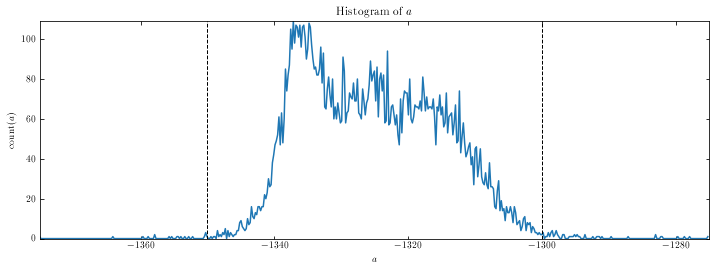

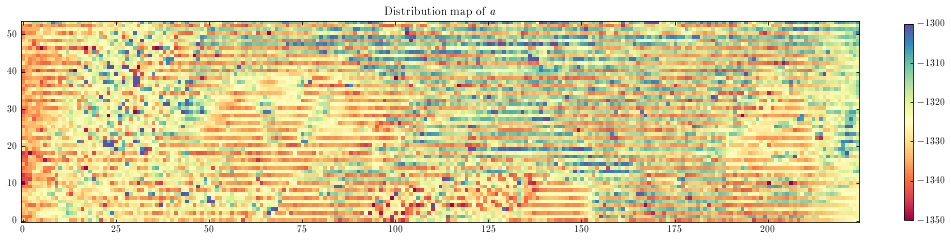

In [16]:
vmin = -1350
vmax = -1300

h,b = histogram(a,bins=512)

figure(figsize=(12,4))

plot(b[:-1],h)
xlim(b[0],b[-1])
ylim(0,h.max())

vlines(vmin,0,h.max(),'k',ls='--',lw=1)
vlines(vmax,0,h.max(),'k',ls='--',lw=1)

xlabel('$a$')
ylabel(r'count($a$)')
title(r'Histogram of $a$')

figure(figsize=(16,8))
title('Distribution map of $a$')
im = imshow(a,cmap='Spectral',vmin=vmin,vmax=vmax)
colorbar(im,fraction=0.011)

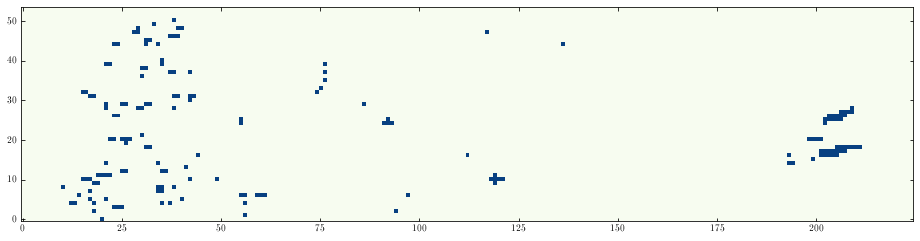

In [81]:
%matplotlib inline

figure(figsize=(16,4))

idx = pm.map_best_index()
imshow(idx,cmap='GnBu')

### Fit errrors

Plotting the maps of the error fit of each phase. 

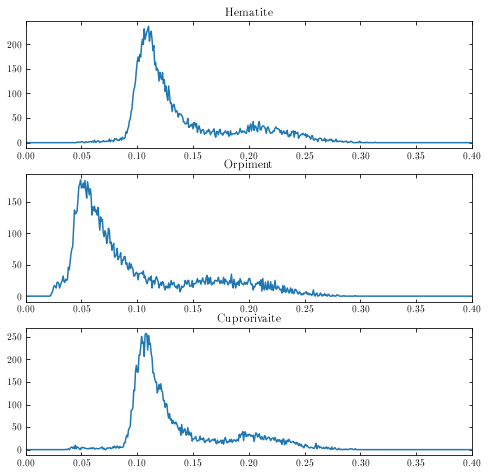

In [17]:
fig,ax = subplots(len(pm.phases),1,figsize=(8,8))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    h,b = histogram(loss[:,:,i],bins=512,range=(0,0.4))
    ax[i].plot(b[:-1],h)
    ax[i].set_xlim(0,0.4)

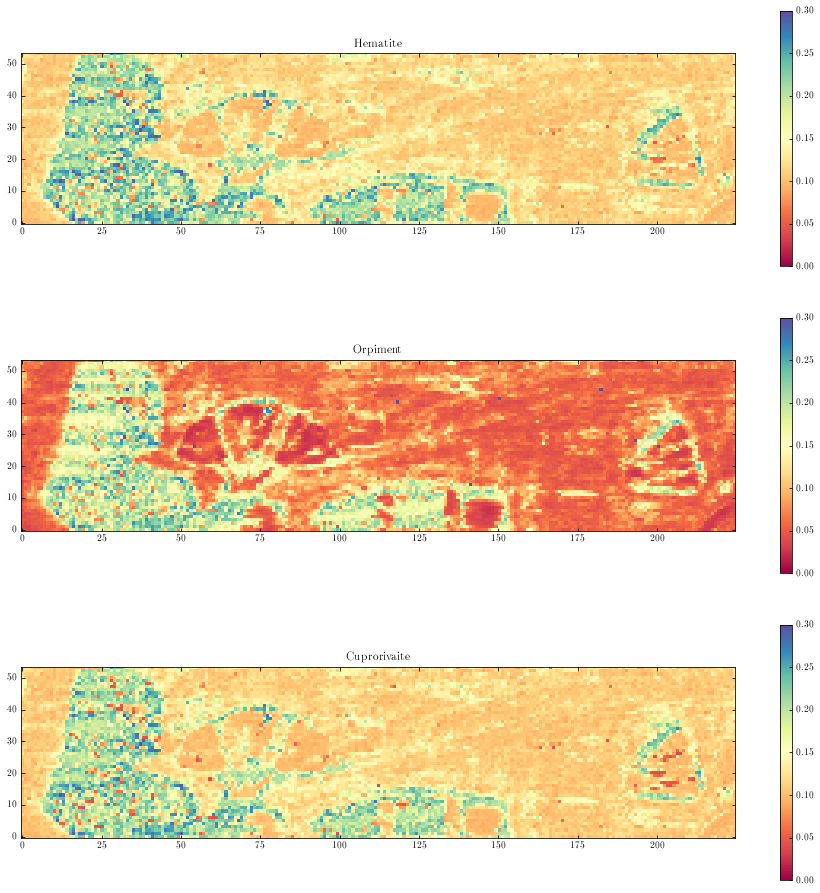

In [18]:
fig,ax = subplots(len(pm.phases),1,figsize=(16,16))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    p = ax[i].imshow(loss[:,:,i],vmin=0,vmax=0.3,cmap='Spectral')
    colorbar(p,ax = ax[i])

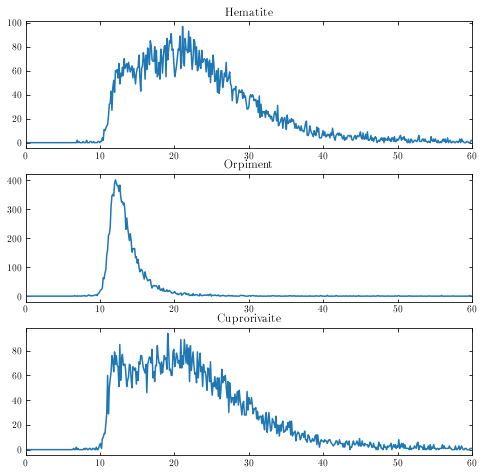

In [19]:
fig,ax = subplots(len(pm.phases),1,figsize=(8,8))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    h,b = histogram(sqrt(loss_0[:,:,i]),bins=512,range=(0,60))
    ax[i].plot(b[:-1],h)
    ax[i].set_xlim(0,60)

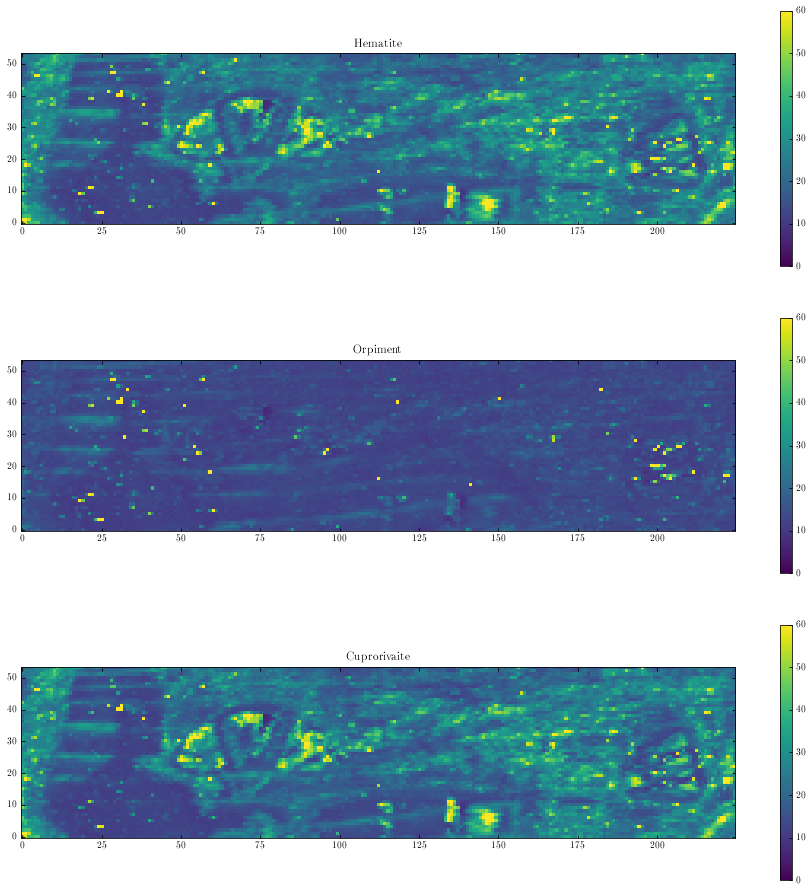

In [20]:
fig,ax = subplots(len(pm.phases),1,figsize=(16,16))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    p = ax[i].imshow(sqrt(loss_0[:,:,i]),vmin=0,vmax=60)
    colorbar(p,ax = ax[i])

[-1339.55547486  2730.74745914    43.20211896]


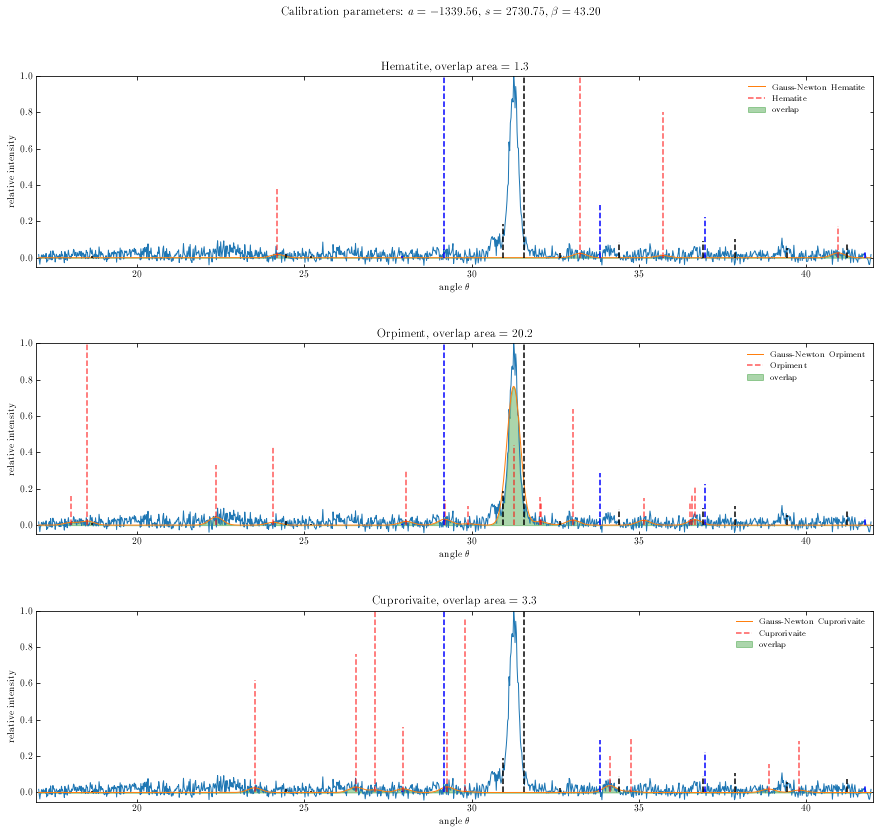

In [92]:
%matplotlib inline
r = pm.get_pixel(74,30)

fig, axes = subplots(len(r), 1, figsize = (15, 4 * len(r)))
fig.subplots_adjust(hspace = 0.4, bottom = 0.06, top = 0.9)
print(r.opt)

fig.suptitle(r'Calibration parameters: $a = %.2f$, $s=%.2f$, $\beta=%.2f$'%(r.opt[0], r.opt[1], r.opt[2]))

for i in range(len(r)):
    ax = axes[i]
    g = r[i]
    sca(ax)

    ax.set_title(f'{g.label}, overlap area = {g.overlap_area():.1f}')
    g.plot_spectra(lw = 1)
    g.plot('-', label='Gauss-Newton %s'%g.label, lw=1)
    g.phase.plot('r', alpha=0.66)

    fill_between(g.theta.squeeze(), g.overlap(), color = 'g', alpha = 0.33, label='overlap')

    legend(frameon = False)
    
    ax.set_ylim(-0.05, 1)
    ax.set_xlim(17, 42)
    ax.set_xlabel(r'angle $\theta$')
    ax.set_ylabel(r'relative intensity')
    
    #lazurite.plot()
    #hydrocerussite.plot()
    
    database['Huntite'][0].plot()
    database['As4 O6'][0].plot(color='b')

In [23]:
cmp_ratio = pm.component_ratio()

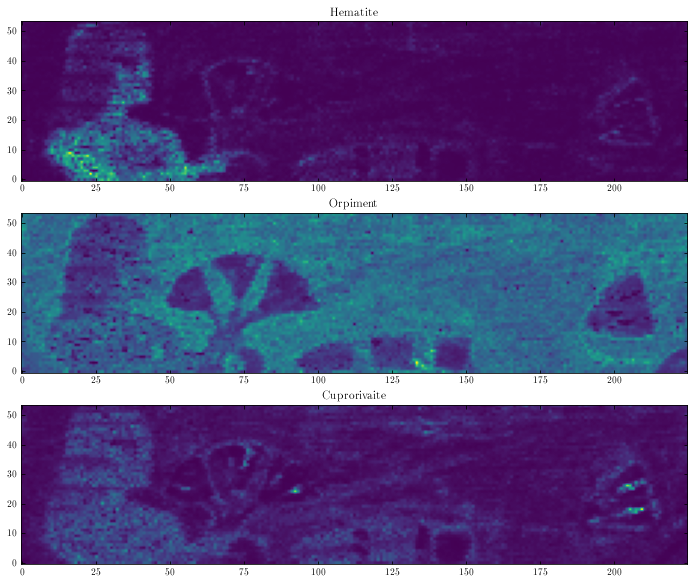

In [24]:
fig,ax= subplots(len(pm.phases),1,figsize=(12,10))
for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    ax[i].imshow(cmp_ratio[:,:,i])

In [25]:
overlap_area = pm.overlap_area()

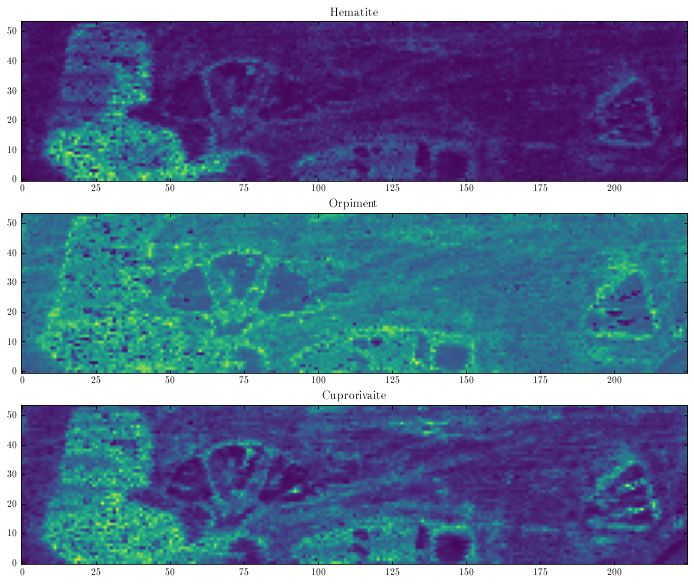

In [26]:
fig,ax= subplots(len(pm.phases),1,figsize=(12,10))
for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    ax[i].imshow(overlap_area[:,:,i])

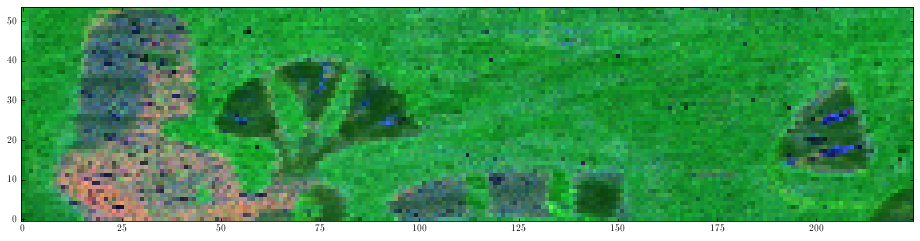

In [79]:
color_cmp = (cmp_ratio)**0.5

color_cmp[:,:,0] /= color_cmp[:,:,0].max()
color_cmp[:,:,1] /= color_cmp[:,:,1].max()
color_cmp[:,:,2] /= color_cmp[:,:,2].max()

figure(figsize=(16,8))
imshow(color_cmp)